In [41]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature.texture import graycomatrix, graycoprops


def weak_label_ephemeral_gully(image, visualize=False):
    """
    Weak labeler for ephemeral gullies using classic computer vision.

    Args:
        image (np.ndarray): Input RGB or grayscale image (H, W, 3) or (H, W)
        visualize (bool): If True, returns overlay for inspection
    
    Returns:
        is_gully (bool): Weak label for presence of ephemeral gully
        (optional) output_img (np.ndarray): Visualization (if visualize=True)
    """

    # --- Step 1: Preprocessing ---
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray = cv2.equalizeHist(gray)

    # --- Step 2: Edge Detection ---
    edges = cv2.Canny(gray, threshold1=10, threshold2=50)

    # --- Step 3: Morphological Filtering ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    # --- Step 4: Contour Filtering ---
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gully_like_shapes = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 5:  # skip tiny shapes
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = max(w / h, h / w)
        if aspect_ratio > 5:  # long and narrow
            gully_like_shapes += 1

    # --- Step 5: Texture Features (LBP + GLCM) ---
    lbp = local_binary_pattern(gray, P=1, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

    glcm = graycomatrix(gray, distances=[5], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]

    # --- Step 6: Heuristic Rule-based Labeling ---
    edge_density = np.sum(opened > 0) / (gray.shape[0] * gray.shape[1])
    is_gully = (gully_like_shapes >= 1 and edge_density > 0.01 and contrast > 5)

    if visualize:
        output_img = image.copy()
        cv2.drawContours(output_img, contours, -1, (0, 255, 0), 2)
        return is_gully, output_img

    return is_gully


Weak label (gully present): True


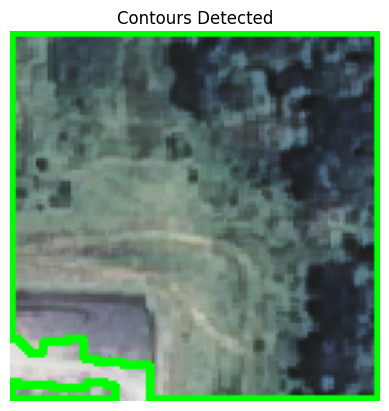

Weak label (gully present): True


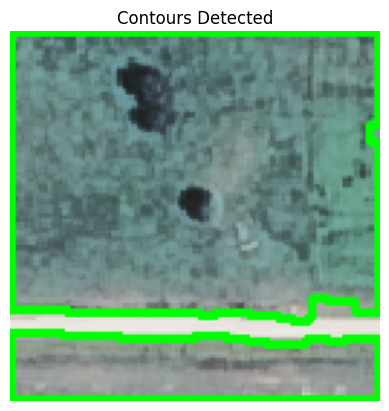

In [42]:
import cv2
import matplotlib.pyplot as plt

for i in range(500):
    
    img = cv2.imread(f"/home/macula/SMATousi/Desktop/gully_test_data/final_pos_neg_test_data_merging_25_2/all_data/rgb_0_tile_{i}.tif")
    if img is not None:
        label, vis = weak_label_ephemeral_gully(img, visualize=True)
        if label == True:
            print("Weak label (gully present):", label)
            
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title("Contours Detected")
            plt.axis("off")
            plt.show()


In [16]:
label


False